In [172]:
import networkx as nx 
import random
import json
import sys
sys.path.append('../')
import config
import os

In [173]:
blacklist = []
data_dir = config.DATA_DIR
cwe_dir = config.CWE_DIR
# Load the JSON data for attack graph
with open(data_dir+'attack_graph.json', 'r') as file:
    a_graph_data = json.load(file)
print("len of links: ",len(a_graph_data['links']))
if not os.path.exists(data_dir+"/plots/"):
    os.makedirs(data_dir+"/plots/")
with open(data_dir+"attack_info.json") as f:
    attack_info = json.load(f)
with open(cwe_dir+config.cwe_dataset+"_info.json") as f:
    cwe_info = json.load(f)
# Create dictionary to store the id_pos and pos_id mapping
doc_id_to_emb_id = {}
emb_id_to_doc_id = {}
attack_weak_range = {}

len of links:  19436


In [177]:
# Create a new graph
a_graph = nx.Graph()
# Add nodes
for node in a_graph_data['nodes']:
    a_graph.add_node(node['id'], **node)
# Add edges
for i in range(len(a_graph_data['links'])):
    source = a_graph_data['links'][i]['source']
    target = a_graph_data['links'][i]['target']
    if(attack_info[source]['Description'].strip()=='' or attack_info[target]['Description'].strip()==''):
        if(attack_info[source]['Description'].strip()==''):
            print("Empty Source: ", source)
        else:
            print("Empty Target: ", target)
        continue
    if(source not in doc_id_to_emb_id and source not in blacklist):
        pos = len(doc_id_to_emb_id.keys())
        doc_id_to_emb_id[source] = pos
        emb_id_to_doc_id[pos]=source
    if(target not in doc_id_to_emb_id and target not in blacklist):
        pos = len(doc_id_to_emb_id.keys())
        doc_id_to_emb_id[target] = pos
        emb_id_to_doc_id[pos]=target
    a_graph.add_edge(source, target)
    #a_graph.add_edge(target, source, weight=1.0-a_graph_data['links'][i]['similarity'])
    # G_all_sim.add_edge(source, target)

Empty Source:  intrusion-set--9559ecaf-2e75-48a7-aee8-9974020bc772
Empty Source:  intrusion-set--68ba94ab-78b8-43e7-83e2-aed3466882c6
Empty Source:  malware--310f437b-29e7-4844-848c-7220868d074a
Empty Source:  malware--911fe4c3-444d-4e92-83b8-cc761ac5fd3b
Empty Source:  malware--911fe4c3-444d-4e92-83b8-cc761ac5fd3b
Empty Target:  malware--911fe4c3-444d-4e92-83b8-cc761ac5fd3b
Empty Source:  malware--911fe4c3-444d-4e92-83b8-cc761ac5fd3b
Empty Target:  malware--911fe4c3-444d-4e92-83b8-cc761ac5fd3b
Empty Source:  malware--911fe4c3-444d-4e92-83b8-cc761ac5fd3b
Empty Source:  malware--911fe4c3-444d-4e92-83b8-cc761ac5fd3b
Empty Source:  malware--911fe4c3-444d-4e92-83b8-cc761ac5fd3b
Empty Source:  intrusion-set--68ba94ab-78b8-43e7-83e2-aed3466882c6
Empty Source:  intrusion-set--68ba94ab-78b8-43e7-83e2-aed3466882c6
Empty Source:  malware--310f437b-29e7-4844-848c-7220868d074a
Empty Source:  intrusion-set--68ba94ab-78b8-43e7-83e2-aed3466882c6
Empty Source:  malware--310f437b-29e7-4844-848c-7220868

In [178]:
a_graph.number_of_edges(), a_graph.number_of_nodes()

(19249, 2047)

In [ ]:
# enterprise without removing empty description: (19310, 2047)

In [179]:
attack_size=len(doc_id_to_emb_id)
attack_weak_range['attack']=(0,attack_size)
attack_size

2043

In [182]:
cwe_info['1004']

{'ID': '1004',
 'Name': "Sensitive Cookie Without 'HttpOnly' Flag",
 'Description': 'Leverage the HttpOnly flag when setting a sensitive cookie in a response.',
 'Extended_Description': "The HttpOnly flag directs compatible browsers to prevent client-side script from accessing cookies. Including the HttpOnly flag in the Set-Cookie HTTP response header helps mitigate the risk associated with Cross-Site Scripting (XSS) where an attacker's script code might attempt to read the contents of a cookie and exfiltrate information obtained. When set, browsers that support the flag will not reveal the contents of the cookie to a third party via client-side script executed via XSS.",
 'Modes_Of_Introduction': '',
 'Common_Consequences': 'Scopes: Confidentiality. Impacts: Read Application Data. Note: If the HttpOnly flag is not set, then sensitive information stored in the cookie may be exposed to unintended parties.Scopes: Integrity. Impacts: Gain Privileges or Assume Identity. Note: If the cookie

In [184]:
# Create a new graph for weakness data
with open(cwe_dir+config.cwe_dataset+'_graph.json') as f:
    w_graph_data = json.load(f)
w_graph = nx.Graph()
# Add nodes
for node in w_graph_data['nodes']:
    w_graph.add_node(node['ID'], **node)

# Add edges
for i in range(len(w_graph_data['links'])):
    source = w_graph_data['links'][i]['source']
    target = w_graph_data['links'][i]['target']
    if((cwe_info[source]['Description'].strip()=='' and cwe_info[source]['Extended_Description'].strip()=='') 
       or (cwe_info[target]['Description'].strip()=='' and cwe_info[target]['Extended_Description'].strip()=='')):
        if(cwe_info[source]['Description'].strip()==''):
            print("Empty Source: ", source)
        else:
            print("Empty Target: ", target)
        continue
    if(source not in doc_id_to_emb_id):
        pos = len(doc_id_to_emb_id.keys())
        doc_id_to_emb_id[source] = pos
        emb_id_to_doc_id[pos]=source
    if(target not in doc_id_to_emb_id):
        pos = len(doc_id_to_emb_id.keys())
        doc_id_to_emb_id[target] = pos
        emb_id_to_doc_id[pos]=target
    w_graph.add_edge(source, target)
    #w_graph.add_edge(target, source, weight=1.0-link['similarity'])
    # G_all_sim.add_edge(source, target)

In [185]:
weak_size = len(doc_id_to_emb_id)-attack_size
attack_weak_range['cwe']=(attack_size,len(doc_id_to_emb_id))
attack_weak_range['cwe']
attack_weak_range['n_nodes']=len(doc_id_to_emb_id)

In [186]:
attack_weak_range

{'attack': (0, 2043), 'cwe': (2043, 2982), 'n_nodes': 2982}

In [187]:
with open(data_dir+'doc_id_to_emb_id.json','w') as fp:
    json.dump(doc_id_to_emb_id,fp)
with open(data_dir+'emb_id_to_doc_id.json','w') as fp:
    json.dump(emb_id_to_doc_id,fp)
with open(data_dir+'attack_weak_range.json','w') as fp:
    json.dump(attack_weak_range,fp)

In [188]:
# Get all connections and shortest path according to hop distance

def get_shortest_path(graph_data, graph):
    all_links = []
    count = 0
    w_dict = {}
    for source in graph.nodes:
        
        for target in graph.nodes: #len(graph_data['links']
            
            if(source==target or (source,target) in w_dict or (target,source) in w_dict):
                continue

            # following line give shortest path according to the weight
            # dist2 = nx.shortest_path_length(graph,source,target2, weight='weight')
            # Following line gives shortes path according to hop distance
            try:
                dist = nx.shortest_path_length(graph,source,target)
                # if((source,target) in w_dict and w_dict[(source,target)]<dist):
                #     dist=w_dict[(source,target)]
                #     print("duplicate", source, " ",target)
                # elif((target,source) in w_dict and w_dict[(target,source)]<dist):
                #     dist=w_dict[(source,target)]
                #     print("duplicate", source, " ",target)
                w_dict[(source,target)] = dist
                #w_dict[(target,source)] = dist
            except:
                count+=1
                #print("No path between "+source+" ",target )
    print("No path: ", count)
    return w_dict

In [189]:
# len = 490891 without visited
# len = 11801 with visited
attack_w_dict = get_shortest_path(a_graph_data,a_graph)


No path:  32676


In [190]:
len(attack_w_dict)

2077743

In [191]:
weakness_w_dict = get_shortest_path(w_graph_data, w_graph)

No path:  0


In [192]:
len(weakness_w_dict.keys())

440391

In [193]:
a_mx_dist = max(list(attack_w_dict.values()))
print(a_mx_dist)

8


In [194]:
w_mx_dist = max(list(weakness_w_dict.values()))
print(w_mx_dist)

13


In [195]:
def create_training(weight_dict):
    pair_data = []
    missing_nodes = set()
    mx_dist = max(list(weight_dict.values()))
    print("max distance ", mx_dist)
    for key in weight_dict.keys():
        if(key[0] in doc_id_to_emb_id):
            source_id = doc_id_to_emb_id[key[0]]
            if(key[1] in doc_id_to_emb_id):
                target_id = doc_id_to_emb_id[key[1]]
                pair_data.append([source_id,target_id, weight_dict[key]/float(mx_dist)])
            else:
                missing_nodes.add(key[1])
        else:
            missing_nodes.add(key[0])
    print(missing_nodes)
    return pair_data, missing_nodes

In [196]:
all_attack_dist, missing_attack = create_training(attack_w_dict)

max distance  8
set()


In [197]:
all_weakness_dist, missing_weakness = create_training(weakness_w_dict)

max distance  13
set()


In [198]:
training_data = all_attack_dist+all_weakness_dist
len(training_data)

2518134

In [199]:
all_weakness_dist[0]

[2043, 2044, 0.07692307692307693]

In [200]:
all_attack_dist_norm = [x for _,_,x in all_attack_dist]

In [201]:
all_weakness_dist_norm = [x for _,_,x in all_weakness_dist]

In [202]:

# one_path_attack_dist = [1.0-item['similarity'] for item in graph_data['links']]
# len(one_path_attack_dist)

In [203]:
import matplotlib.pyplot as plt

def histogram(all_sim,file, title):
    # Plot histogram with 5 bins
    plt.hist(all_sim, bins=50, edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.savefig(file, dpi=300)
    # Show plot
    plt.show()

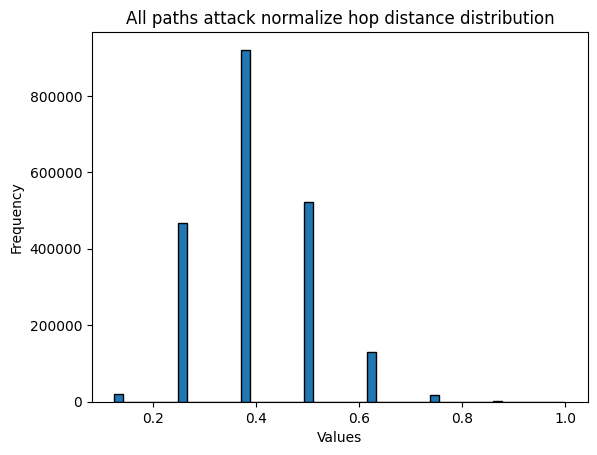

In [204]:
histogram(all_attack_dist_norm,data_dir+'plots/attack_norm_hop_distance_distribution.png', 'All paths attack normalize hop distance distribution')

In [205]:
attack_hop_dist = [x*a_mx_dist for _,_,x in all_attack_dist]

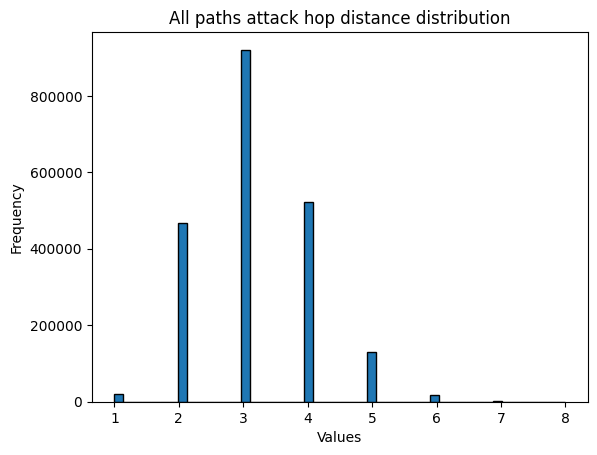

In [206]:
histogram(attack_hop_dist,data_dir+'plots/attack_hop_distance_distribution.png', 'All paths attack hop distance distribution')

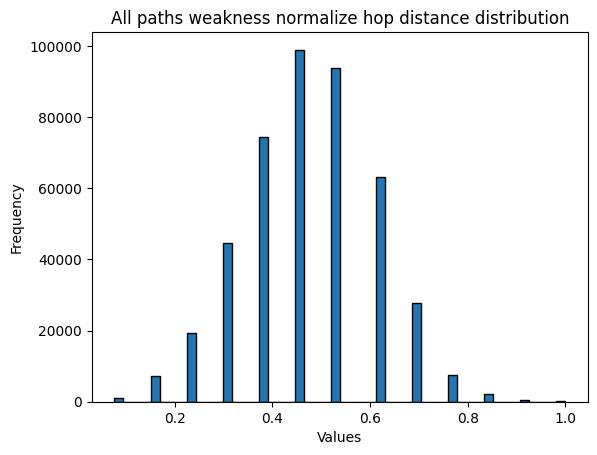

In [207]:
histogram(all_weakness_dist_norm,data_dir+'plots/weakness_norm_hop_distance_distribution.png', 'All paths weakness normalize hop distance distribution')

In [208]:
weakness_hop_dist = [x*w_mx_dist for _,_,x in all_weakness_dist]

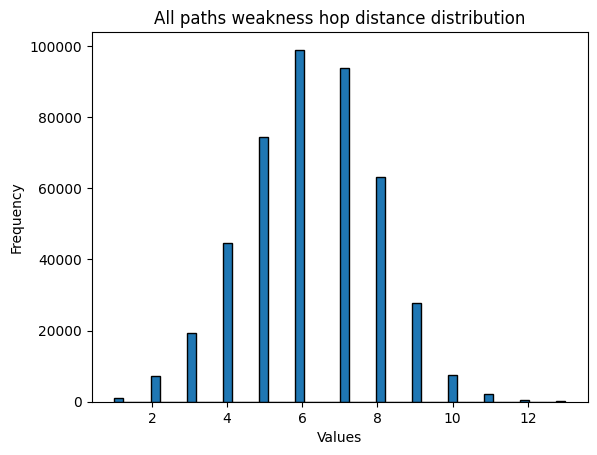

In [209]:
histogram(weakness_hop_dist,data_dir+'plots/weakness_hop_distance_distribution.png', 'All paths weakness hop distance distribution')

In [210]:
training_data = all_attack_dist+all_weakness_dist

In [211]:
len(training_data)

2518134

In [212]:
import numpy as np
np.save(data_dir+'hop_training_data.npy', np.array(training_data)) # save
#new_num_arr = np.load('data.npy') # load

In [213]:
def get_hop_sim_matrix(all_dist, size, isAttack):
    hop_sim_matrix = [[0 for _ in range(size)] for _ in range(size)]
    for n1,n2,dist in all_dist:
        if(not isAttack):
            n1=n1-attack_size
            n2=n2-attack_size
        # print("n1",n1)
        # print("n2",n2)
        
        hop_sim_matrix[n1][n2]=1.0001-dist
        hop_sim_matrix[n2][n1]=1.0001-dist
    return hop_sim_matrix

In [214]:
weakness_hop_sim_matrix = get_hop_sim_matrix(all_weakness_dist, weak_size, False)

In [215]:
attack_hop_sim_matrix = get_hop_sim_matrix(all_attack_dist, attack_size, True)

In [216]:
count=0
for i in range(len(attack_hop_sim_matrix)):
    for j in range(len(attack_hop_sim_matrix[0])):
        if(attack_hop_sim_matrix[i][j]==0):
            count+=1
print(count)

18363


In [217]:
np.save(data_dir+'weakness_hop_sim_matrix.npy', np.array(weakness_hop_sim_matrix)) # save

In [218]:
np.save(data_dir+'attack_hop_sim_matrix.npy', np.array(attack_hop_sim_matrix)) # save